# Coursework 2 

The aim of this coursework is to implement and validate a VAE-GAN as per the original paper by ABL Larsen et al.
https://arxiv.org/abs/1512.09300

<img src="https://miro.medium.com/max/2992/0*KEmfTtghsCDu6UTb.png" width="400">


Spend some time reading the paper and start working on the code below. Some boilerplate code is already provided.


In [0]:
import os
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import argparse
from skimage import transform

from glob import glob
from os.path import join
from os import listdir
from pathlib import Path



from torch import optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.nn.modules.loss import L1Loss
from torch.nn.modules.loss import MSELoss
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torch.utils.data
import torchvision.utils as vutils
import torch.nn.functional as functional
from torch.nn.modules import Upsample as upsampling

def numpy_from_tensor(x):
  return x.detach().cpu().numpy()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=19mbvpXW_0mpOuWA0scpfQVcQ6GH7giSH
!unzip -q ImagesHands.zip

Downloading...
From: https://drive.google.com/uc?id=19mbvpXW_0mpOuWA0scpfQVcQ6GH7giSH
To: /content/ImagesHands.zip
41.8MB [00:00, 158MB/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Should have probably created a bean like object for this
INPUT_CHANNELS_LABEL = "inputChannels"
BATCH_SIZE_LABEL = "batchSize"
HIDDEN_SIZE_LABEL = "hiddenSize"
MAX_EPOCHS_LABEL = "maxEpochs"
LEARNING_RATE_LABEL = "learningRate"
ALPHA_LABEL = "alpha"
BETA_LABEL = "beta"
GAMMA_LABEL = "gamma"
GAN_CONTROL_LABEL = "ganControl"
SAMPLE_WHILE_TRAINING_LABEL = "sampleWhileTraining"
PERMANENT_PATH_LABEL = 'permanentPath'
FIXED_BATCH_LABEL = "fixedBatch"
FIXED_NOISE_LABEL = "fixedNoise"
TRAIN_LOADER_LABEL = "trainLoader"

class Utils():
  """
  Attempt at creating a utils class. Turned out a bit messy but still useful.
  """

  def __init__(self):
    self.encoderModelName = "encoder_epoch_%d.pt"
    self.decoderModelName = "decoder_epoch_%d.pt"
    self.discriminatorModelName = "discriminator_epoch_%d.pt"
    self.imageFormat = 'png'
    self.imageFolder = 'generatedImages'
    self.reconstructedFolder = self.imageFolder + '/reconstructed/'
    self.sampleFolder = self.imageFolder + '/samples/'


  def showImage(self, fileName, img):
    if not isinstance(img, np.ndarray):
      img = numpy_from_tensor(img)
    fig = plt.figure(figsize = (20,8))
    fig.suptitle(fileName, fontsize=14, fontweight='bold')
    plt.imshow(img, cmap="gray")

  def saveImage(self, path, fileName, img):
    if not isinstance(img, np.ndarray):
      img = numpy_from_tensor(img)
    self.createFolder(path)
    imagePath = self.getImagePath(path, fileName)
    plt.imsave(imagePath, img, cmap="gray")
    #vutils.save_image(samples.data, imagePath, normalize=True)

  def getGeneratedImages(self, generator, fixedBatch, fixedNoise, epoch=None):
    reconstructedImage = self.getReconstructedImage(generator, fixedBatch, epoch)
    sampleImage = self.getSampleImage(generator, fixedNoise, epoch)
    return reconstructedImage, sampleImage

  def getReconstructedImage(self, generator, fixedBatch, epoch=None):
    _, _, reconstructedImages = generator(fixedBatch)
    image = self.getGridImage(reconstructedImages)
    imageName = 'reconstructed_sample_epoch_%d' % epoch
    return (imageName, image)  

  def getSampleImage(self, generator, fixedNoise, epoch=None):
    samples = generator.decoder(fixedNoise)
    image = self.getGridImage(samples)
    imageName = 'sample_epoch_%d' % epoch
    return (imageName, image)

  def getGridImage(self, image):
    imageGrid = make_grid(image.data)
    return np.squeeze(next(iter(imageGrid)))
  
  def saveModel(self, epoch, encoder, decoder, discriminator=None, permanentPath=None):
    # Get the paths
    encoderPath, decoderPath, discriminatorPath = self.getModelPaths(epoch, permanentPath)

    # Save models to path
    torch.save(encoder.cpu().state_dict(), encoderPath)
    encoder.cuda()
    torch.save(decoder.cpu().state_dict(), decoderPath)
    decoder.cuda()
    if discriminator:
      torch.save(discriminator.cpu().state_dict(), discriminatorPath)
      discriminator.cuda()
      
  def loadModel(self, epoch, trainingParameters, permanentPath=None):
    # Get the paths
    encoderPath, decoderPath, discriminatorPath = self.getModelPaths(epoch, permanentPath)
    
    # Initialise the models
    generator = VaeGanNetwork(trainingParameters[INPUT_CHANNELS_LABEL], trainingParameters[HIDDEN_SIZE_LABEL]).cuda()
    if not trainingParameters[GAN_CONTROL_LABEL]:
      discriminator = Discriminator(trainingParameters[INPUT_CHANNELS_LABEL]).cuda()
    decoder = generator.decoder
    encoder = generator.encoder
    
    # Load the models
    decoder.load_state_dict(torch.load(decoderPath))
    decoder.cuda()
    encoder.load_state_dict(torch.load(encoderPath))
    encoder.cuda()
    if trainingParameters[GAN_CONTROL_LABEL]:
      return encoder, decoder, None
    discriminator.load_state_dict(torch.load(discriminatorPath))
    discriminator.cuda()
    return encoder, decoder, discriminator

  def createFolder(self, path):
    if path and not os.path.isdir(path):
      os.makedirs(path)

  def showCurrentResults(self, epoch, maxEpochs, discriminatorRealList, discriminatorRecEncoderList, discriminatorRecNoiseList, 
                         discriminatorList, generatorLossList, recLossList, priorLossList):
  """
  Input here should have probably been a dictionary
  """
    print('[%d/%d]: D_real=%.4f, D_enc=%.4f, D_noise=%.4f, Loss_D=%.4f, Loss_G=%.4f, rec_loss=%.4f, prior_loss=%.4f'
        % (epoch,
            maxEpochs,
            torch.mean(torch.stack(discriminatorRealList)),
            torch.mean(torch.stack(discriminatorRecEncoderList)),
            torch.mean(torch.stack(discriminatorRecNoiseList)),
            torch.mean(torch.stack(discriminatorList)),
            torch.mean(torch.stack(generatorLossList)),
            torch.mean(torch.stack(recLossList)),
            torch.mean(torch.stack(priorLossList))))
    
  def getImagePath(self, path, fileName):
    if path:
      return "%s%s.%s" % (path, fileName, self.imageFormat)
    return "%s.%s" % (fileName, self.imageFormat)
    
  def getReconstructedImageFolder(self):
    return self.reconstructedFolder

  def getSampleImageFolder(self):
    return self.sampleFolder

  def getModelPaths(self, epoch, permanentPath):
    encoderPath = self.getEncoderPath(epoch, permanentPath)
    decoderPath = self.getDecoderPath(epoch, permanentPath)
    discriminatorPath = self.getDiscriminatorPath(epoch, permanentPath)
    return encoderPath, decoderPath, discriminatorPath

  def getDecoderPath(self, epoch, permanentPath):
    modelName = self.decoderModelName % epoch
    return self.getPath(modelName, permanentPath)

  def getEncoderPath(self, epoch, permanentPath):
    modelName = self.encoderModelName % epoch
    return self.getPath(modelName, permanentPath)

  def getDiscriminatorPath(self, epoch, permanentPath):
    modelName = self.discriminatorModelName % epoch
    return self.getPath(modelName, permanentPath)

  def getPath(self, modelName, permanentPath):
    if permanentPath:
      return F"{permanentPath}/{modelName}" 
    return modelName


torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])


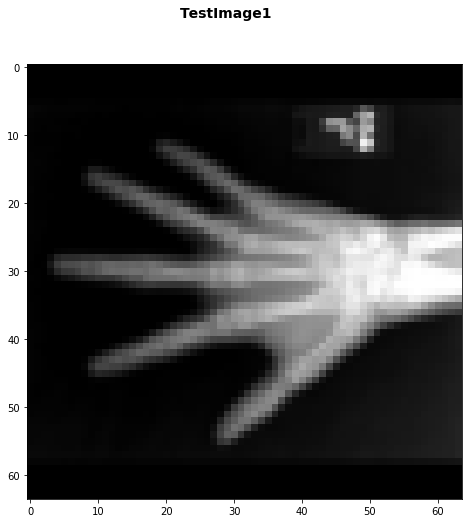

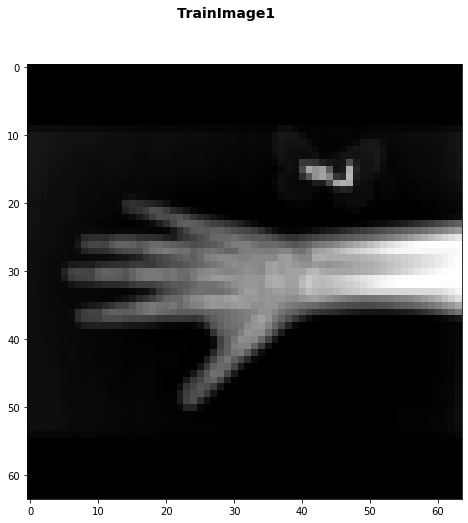

In [5]:
class NiftyDataset(Dataset):
  '''
    Class that loads nii files, resizes, transforms and normalises them
  '''
  def __init__(self, root_dir=None, resizeSize=None, transform=None, normalise=False):
    '''
      root_dir - string - path towards the folder containg the data
      resizeSize - int - The new imae size
      transform - torch.transform - The transform
      normalise - boolean - Whether to normalise or not
    '''
    # Save the root_dir as a class variable
    self.root_dir = root_dir
    # Save the filenames in the root_dir as a class variable
    self.filenames = listdir(self.root_dir)
    self.resizeSize = resizeSize
    self.transform = transform
    self.normalise = normalise
  
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self,idx):
    # Fetch file filename
    img_name = self.filenames[idx]
    # Load the nifty image
    img = nib.load(os.path.join(self.root_dir,img_name))
    # Get the voxel values as a numpy array
    img = np.array(img.get_fdata())
    # Expanding the array with 1 new dimension as feature channel
    img = np.expand_dims(img, 0)
    if self.resizeSize is not None:
      img = transform.resize(img, (1, self.resizeSize, self.resizeSize)) 
    if self.transform is not None:
      # img = np.transpose(img, (1, 2, 0))
      img = self.transform(img)
      # img = np.transpose(img, (0, 1, 2))
    if self.normalise:
      img = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
    return img
    
    def __len__(self):
        return len(self.dataset)


BATCH_SIZE = 32
NUM_WORKERS = 4
IMAGE_SIZE = 64
imageTransforms = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize([0.5], [0.5])])

dataset = NiftyDataset(root_dir=join("/content/ImagesHands/"), resizeSize = IMAGE_SIZE, transform=None, normalise=True)

# Create the required DataLoaders for training and testing
validationSplit = .1
datasetSize = len(dataset)
shuffleDataset = True
randomSeed= 42

indices = list(range(datasetSize))
split = int(np.floor(validationSplit * datasetSize))
if shuffleDataset :
    np.random.seed(randomSeed)
    np.random.shuffle(indices)
trainIndices, testIndices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
trainSampler = SubsetRandomSampler(trainIndices)
testSampler = SubsetRandomSampler(testIndices)

trainLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=trainSampler)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=testSampler)

# Check that everything works (i.e. loading an image, showing it and saving it)
utils = Utils()
dataTrain = next(iter(trainLoader))
dataTest = next(iter(testLoader))
print (dataTrain.size())
print (dataTest.size())
imageTrain = np.squeeze(next(iter(dataTrain)))
imageTest = np.squeeze(next(iter(dataTest)))
utils.showImage("TestImage1", imageTest)
utils.showImage("TrainImage1", imageTrain)
utils.saveImage(None, "TestImage1", imageTrain)
utils.saveImage(utils.getReconstructedImageFolder(), "TestImage2", imageTrain)
utils.saveImage(utils.getSampleImageFolder(), "TestImage3", imageTrain)


# Part 1 - Encoder & Decoder

Implement an encoder and decoder as per the Unsupervised Learning Lecture.
Feel free to introduce architectural variations that you think are useful. 

*Comment all the code you write appropriateley* 


In [0]:
# YOUR CODE HERE
class EncoderBlock(nn.Module):
    '''
    Define the Encoder block for the Encoder
    '''
    def __init__(self, inChannels, outChannels):
        super(EncoderBlock, self).__init__()
        
        # Set up the layer and batch norm
        self.conv = nn.Conv2d(in_channels = inChannels, out_channels = outChannels, kernel_size = 5, 
                              padding = 2, stride = 2, bias=False)
        self.bn = nn.BatchNorm2d(outChannels)

    # Forward pass
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = functional.leaky_relu(x, 0.2, inplace =  True)
        return x


class DecoderBlock(nn.Module):
    '''
    # Definine the Decoder Block for the Decoder
    '''
    def __init__(self, inChannels, outChannels):
        super(DecoderBlock, self).__init__()
        
        # Set up upsampling and batch norm
        self.conv = nn.Sequential(upsampling(scale_factor = 2, mode = 'nearest'), 
                                  nn.Conv2d(inChannels, outChannels, kernel_size = 5, 
                                            padding = 2, stride = 1, bias = False))
        self.bn = nn.BatchNorm2d(outChannels)
    
    # Forward pass
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = functional.leaky_relu(x, 0.2, inplace = True)
        return x    

In [0]:
class Encoder(nn.Module):
    def __init__(self, inChannels = 1):
        super(Encoder, self).__init__()
        self.size = inChannels
        layers = []

        # Define the first layer to 64 and double it for the rest
        for i in range(3):
            if i == 0:
                layers.append(EncoderBlock(inChannels=self.size, outChannels=64))
                self.size = 64
            else:
                layers.append(EncoderBlock(inChannels=self.size, outChannels=self.size * 2))
                self.size *= 2

        # Final shape is batch size x 256 x 8 x 8 
        self.conv = nn.Sequential(*layers)
        for module in self.modules():
          if isinstance(module, nn.Conv2d):
            torch.nn.init.xavier_normal_(module.weight.data)
        
        self.meanFc = nn.Sequential(nn.Linear(in_features = 8*8*256, out_features = 2048), 
                                     nn.BatchNorm1d(2048), nn.LeakyReLU(0.2, inplace = True))
        self.logvarFc = nn.Sequential(nn.Linear(in_features = 8*8*256, out_features = 2048), 
                                     nn.BatchNorm1d(2048), nn.LeakyReLU(0.2, inplace = True))
    # Forward pass
    def forward(self, x):
        batchSize = x.size()[0]
        x = self.conv(x)
        x = x.view(batchSize, -1)
        mean = self.meanFc(x)
        logvar = self.logvarFc(x)
        return mean, logvar 

In [0]:
class Decoder(nn.Module):
    def __init__(self, hiddenSize=2048, reconstructionSize=256):
        super(Decoder, self).__init__()

        self.reconstructionSize = reconstructionSize

        # Define fully connected layer (input size of Batch_sizex256x8x8)
        self.fc = nn.Sequential(nn.Linear(in_features=hiddenSize, out_features=8 * 8 * reconstructionSize, bias=False),
                                nn.BatchNorm1d(num_features=8 * 8 * reconstructionSize), nn.LeakyReLU(0.2, inplace=True))
        self.size = reconstructionSize

        # Define upsampling layers
        layers = []
        layers.append(DecoderBlock(inChannels=self.size, outChannels=self.size))
        layers.append(DecoderBlock(inChannels=self.size, outChannels=self.size // 2))

        # Update size
        self.size = self.size // 2

        layers.append(DecoderBlock(inChannels=self.size, outChannels=self.size // 4))

        # Update size
        self.size = self.size // 4

        # Final convolutional layer to output 1 channel with tanh
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=1, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers)
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                torch.nn.init.xavier_normal_(module.weight.data)

    # Forward pass
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.reconstructionSize, 8, 8)
        x = self.conv(x)
        return x



### REPORT

*Describe here the resoning for using the architecture above, what other decisions could have been made, and what would be their advantages and disadvantages*

_______________________________


Here we describe a simple Encoder and Decoder. 

They each use their individual Block class (EncoderBlock and DecoderBlock). The layers are defined as mentioned in the paper.

Perhaps further inheritance could have been employed here. Having an AbstractBlock to define the block's signature would have been useful. One of the reasons this wasn't done was that it's not necessary for this implementation and could have perhaps created some confusion

_______________________________


# Part 2 - Adversarial Learning (discriminator) 

Now, implement the adversarial learning loss, as per the paper from Larsen et al. Feel free change the architecture of the discriminator proposed in Larsen et al. as you please. 

In [0]:
class Discriminator(nn.Module):
    def __init__(self, inChannels):
        super(Discriminator, self).__init__()

        # Define the layers of the discriminator as defined in Larsen et al. 
        layers = []

        # First convolutional layer with BatchNorm and ReLU
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels=inChannels, out_channels=32,
                      kernel_size=5, stride=1, padding=2), nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True)
        ))

        # Second convolutional layer with BatchNorm and ReLU
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=128,
                      kernel_size=5, stride=2, padding=2), nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ))

        # Third convolutional layer with BatchNorm and ReLU
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=5, stride=2, padding=2), nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ))

        # Fourth convolutional layer with BatchNorm and ReLU
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=5, stride=2, padding=2), nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ))

        self.conv = nn.Sequential(*layers)

        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                torch.nn.init.xavier_normal_(module.weight.data)

        # Final two fully connected layers with sigmoid to obtain a final prediction (True or Fake)
        self.fc = nn.Sequential(nn.Linear(in_features=8 * 8 * 256, out_features=512, bias=False),
                                nn.LeakyReLU(0.2, inplace=True))
        self.sigmoid = nn.Sequential(nn.Linear(in_features=512, out_features=1),
                                     nn.Sigmoid())

    # Forward pass
    def forward(self, x):
        batchSize = x.size()[0]
        x = self.conv(x)
        x = x.view(batchSize, -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

    # Similarity 
    def similarity(self, x):
        batchSize = x.size()[0]
        x = self.conv(x)
        x = x.view(batchSize, -1)
        x = self.fc(x)
        return x

### REPORT

*Describe here your decriminator and your though process for designing a good architecture*

_______________________________


Here we try to keep the discriminator as simple as possible. Therefore, we try to minimise any dependencies from outside logic.
It is comprised of three parts, the init function, the forward pass and the similarity function.

Some improvements that could have been done here such as not hard coding any values (such as inChannels and outChannels). Perhaps this is debatable as this is a very specific implementation and so "not allowing" the change of said values is not necessarily wrong. It would be worth testing very layer sizes though and look at the results.

Again since we know the purpose of this implementation is very limited, we don't overdo it with inheritance to keep it simple.

_______________________________


# Part 3 - Code Processor and Network 

In order to obtain a VAE-GAN, you now need to implement a the VAE code processor using either a Dense AutoEncoder or a spatial Code Processor. Implement the code processor of your choice as per the Unsupervised Learning lecture, and glue the encoder, decoder decriminator and code processor into a single network. Write your code below and report on your decisions in the cell after your code. 

In [0]:
class VaeGanNetwork(nn.Module):
    def __init__(self, inputChannels, hiddenSize, reconstructionSize=256):
        super(VaeGanNetwork, self).__init__()
        self.inputChannels = inputChannels
        self.hiddenSize = hiddenSize
        self.reconstructionSize = reconstructionSize

        # Define VAE components (encoder and decoder)
        self.encoder = Encoder(inChannels=inputChannels)
        self.decoder = Decoder(hiddenSize=hiddenSize, reconstructionSize=reconstructionSize)
        self.initParameters()

    def initParameters(self):
      for module in self.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
          if hasattr(module, "weight") and module.weight is not None and module.weight.requires_grad:
            scale = 1 / np.sqrt(np.prod(module.weight.shape[1:]))
            scale /= np.sqrt(3)
            nn.init.uniform_(module.weight, -scale, scale)

          if hasattr(module, "bias") and module.bias is not None and module.bias.requires_grad:
            nn.init.constant_(module.bias, 0.0)

    # Forward pass
    def forward(self, x):
        batch_size = x.size()[0]
        # Get the mean and variance
        mean, logVars = self.encoder(x)
        # True variance not logarithmic
        std = logVars.mul(0.5).exp()
        # Create a random sample
        randomisedX = Variable(torch.randn(batch_size, self.hiddenSize)).cuda()

        x = mean + std * randomisedX
        x = self.decoder(x)

        return mean, logVars, x


### REPORT

*Describe here the resoning for the code processor you chose and any particular features of your network. Describe also other aspects of the network such as: the loss function, how different parts of the network are connected to each other, and any particular charateristic of the network that you find of relevance*

_______________________________


We use a spatial autoencoder to preserve the initial dimensions of the image. Again, since the implementation is limited, we omit the use of a code processor to keep things simple. Perhaps in the case of the code processor it shouldn't have been skipped (as it was for the AbstractBlock mentioned in the previous section).

The network connects the encoder and the decoder and through it can generate both reconstructions and samples we have trained/are training the network for.

All the losses are calculated within the training at each iteration.

_______________________________


# Part 4 - Training Loop

Now, define the training loop for the VAE-GAN and train the network itself. As a suggestion, follow Algorithm 1 from the original paper. Feel free to introduce any modifications in the algorithm, as long as you justify them below. Dont forget to introduce the scaling factor $\gamma$ to control the balance between the reconstruction and other losses.

In [0]:
# YOUR CODE HERE
def experiment(trainingParameters):
  # Create models
  generator = VaeGanNetwork(trainingParameters[INPUT_CHANNELS_LABEL], trainingParameters[HIDDEN_SIZE_LABEL]).cuda()
  if trainingParameters[GAN_CONTROL_LABEL]:
    return getVaeGenerator(trainingParameters, generator)
  return getVaeGanGenerator(trainingParameters, generator)

def getVaeGanGenerator(trainingParameters, generator):
  discriminator = Discriminator(trainingParameters[INPUT_CHANNELS_LABEL]).cuda()

  # Assign encoders and loss
  criterion = nn.BCELoss()
  criterion.cuda()
  encoderOptimiser, decoderOptimiser, discriminatorOptimiser = getOptimisers(trainingParameters, generator, discriminator)

  # Train the network
  generator = trainVaeGan(discriminator, generator, encoderOptimiser, 
          decoderOptimiser, discriminatorOptimiser, criterion, trainingParameters)
  return generator
  
def getVaeGenerator(trainingParameters, generator):
  # Assign encoders and loss
  optimiser = getOptimisers(trainingParameters, generator)
  l1Loss = L1Loss()
  l2Loss = MSELoss()

  # Train the network
  generator = trainVae(generator, optimiser, l1Loss, l2Loss, trainingParameters)
  return generator

def trainVaeGan(discriminator, generator, optimiserEncoder, 
          optimiserDecoder, optimiserDiscriminator, criterion, trainingParameters):
  
  # Assign needed parameters
  maxEpochs = trainingParameters[MAX_EPOCHS_LABEL]
  alpha = trainingParameters[ALPHA_LABEL]
  beta = trainingParameters[BETA_LABEL]
  gamma = trainingParameters[GAMMA_LABEL]
  hiddenSize = trainingParameters[HIDDEN_SIZE_LABEL]
  sampleWhileTraining = trainingParameters[SAMPLE_WHILE_TRAINING_LABEL]
  trainingLoader = trainingParameters[TRAIN_LOADER_LABEL]

  for epoch in range(maxEpochs):
      discriminatorRealList, discriminatorRecEncoderList, discriminatorRecNoiseList, discriminatorList = [], [], [], []
      generatorLossList, recLossList, priorLossList = [], [], []
      for data in trainingLoader:
          batchSize = data.size()[0]
          onesLabel = Variable(torch.ones(batchSize)).cuda()
          zerosLabel = Variable(torch.zeros(batchSize)).cuda()

          data = data.to(device=device, dtype=torch.float)
          dataVariable = Variable(data).cuda()

          mean, logvar, encoderReconstruction = generator(dataVariable)
          noiseVariable = Variable(torch.randn(batchSize, hiddenSize)).cuda()
          reconstructionNoise = generator.decoder(noiseVariable)

          # train the Discriminator
          # Pass x
          output = discriminator(dataVariable)
          errorDReal = criterion(output, onesLabel)
          discriminatorRealList.append(output.data.mean())
          # Pass encoder's x
          output = discriminator(encoderReconstruction)
          errorDRecEncoder = criterion(output, zerosLabel)
          discriminatorRecEncoderList.append(output.data.mean())
          # Pass noise
          output = discriminator(reconstructionNoise)
          errorDRecNoise = criterion(output, zerosLabel)
          discriminatorRecNoiseList.append(output.data.mean())

          discriminatorImageLoss = errorDReal + errorDRecEncoder + errorDRecNoise
          discriminatorList.append(discriminatorImageLoss.data.mean())
          optimiserDiscriminator.zero_grad()
          discriminatorImageLoss.backward(retain_graph=True)
          optimiserDiscriminator.step()

          # train the Decoder
          # Pass x
          output = discriminator(dataVariable)
          errorDReal = criterion(output, onesLabel)
          # Pass encoder's x
          output = discriminator(encoderReconstruction)
          errorDRecEncoder = criterion(output, zerosLabel)
          # Pass noise
          output = discriminator(reconstructionNoise)
          errorDRecNoise = criterion(output, zerosLabel)

          # Calculate similarity
          similarityRecEncoder = discriminator.similarity(encoderReconstruction)
          similarityData = discriminator.similarity(dataVariable)

          discriminatorImageLoss =  errorDRecEncoder + errorDRecNoise
          generatorImageLoss = -discriminatorImageLoss

          generatorLossList.append(generatorImageLoss.data.mean())
          recLoss = ((similarityRecEncoder - similarityData) ** 2).mean()
          recLossList.append(recLoss.data.mean())
          decoderError = gamma * recLoss + generatorImageLoss

          optimiserDecoder.zero_grad()
          decoderError.backward(retain_graph=True)
          optimiserDecoder.step()

          # train the Encoder
          priorLoss = 1 + logvar - mean.pow(2) - logvar.exp()
          priorLoss = (-0.5 * torch.sum(priorLoss)) / torch.numel(mean.data)
          priorLossList.append(priorLoss.data.mean())
          encoderError = beta * recLoss + priorLoss

          optimiserEncoder.zero_grad()
          encoderError.backward()
          optimiserEncoder.step()
      if isTimeToSave(epoch, maxEpochs):
        utils.saveModel(epoch, generator.encoder, generator.decoder, discriminator, trainingParameters[PERMANENT_PATH_LABEL])
      
      if sampleWhileTraining and isTimeToSave(epoch, maxEpochs):
        generateImage(generator, trainingParameters, epoch)
      utils.showCurrentResults(epoch, maxEpochs, discriminatorRealList, discriminatorRecEncoderList, discriminatorRecNoiseList, 
                              discriminatorList, generatorLossList, recLossList, priorLossList)
  return generator

def trainVae(generator, optimiser, l1Loss, l2Loss, trainingParameters):
  maxEpochs = trainingParameters[MAX_EPOCHS_LABEL]
  sampleWhileTraining = trainingParameters[SAMPLE_WHILE_TRAINING_LABEL]
  trainingLoader = trainingParameters[TRAIN_LOADER_LABEL]

  for epoch in range(maxEpochs):
    for data in trainingLoader:
      data = data.to(device, dtype=torch.float)

      # Zero the parameter gradients
      optimiser.zero_grad()

      # Run the VAE
      mean, logvar, encoderReconstruction = generator(data)

      # Calculate the loss
      l1 = l1Loss(data, encoderReconstruction)
      l2 = l2Loss(data, encoderReconstruction)
      loss = l1 + l2
      
      logvar = torch.flatten(logvar, start_dim=1)
      mean = torch.flatten(mean, start_dim=1)
      kl_divergence = (
        -0.5 * 
        torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
      )
      kl_divergence = kl_divergence.mean()
      loss += kl_divergence

      # Back-propagation of gradients
      loss.backward()

      # Optimize
      optimiser.step()
      
    if isTimeToSave(epoch, maxEpochs):
      utils.saveModel(epoch, generator.encoder, generator.decoder, None, trainingParameters[PERMANENT_PATH_LABEL])        
    if sampleWhileTraining and isTimeToSave(epoch, maxEpochs):
      generateImage(generator, trainingParameters, epoch)
    print("[%d/%d]: Total Loss=%d" % (epoch, maxEpochs, numpy_from_tensor(loss)))
  return generator

def generateImage(generator, trainingParameters, epoch):
  reconstructedImage, sampleImage = utils.getGeneratedImages(generator, fixedBatch, fixedNoise, epoch)
  utils.saveImage(utils.getReconstructedImageFolder(), reconstructedImage[0], reconstructedImage[1])
  utils.saveImage(utils.getSampleImageFolder(), sampleImage[0], sampleImage[1])

def isTimeToSave(epoch, maxEpoch):
  if maxEpoch - 1 == epoch:
    return True
  return epoch % 10 == 0

def getOptimisers(trainingParameters, generator, discriminator=None):
  if trainingParameters[GAN_CONTROL_LABEL]:
    return optim.Adam(generator.parameters(), lr=0.0001)
  learningRate = trainingParameters[LEARNING_RATE_LABEL]
  alpha = trainingParameters[ALPHA_LABEL]
  encoderOptimiser = optim.RMSprop(generator.encoder.parameters(), lr=learningRate)
  decoderOptimiser = optim.RMSprop(generator.decoder.parameters(), lr=learningRate)
  discriminatorOptimiser = optim.RMSprop(discriminator.parameters(), lr=learningRate * alpha)
  return encoderOptimiser, decoderOptimiser, discriminatorOptimiser


In [0]:
# define constants
trainingParameters = {}
trainingParameters[TRAIN_LOADER_LABEL] = trainLoader
trainingParameters[INPUT_CHANNELS_LABEL] = 1
trainingParameters[BATCH_SIZE_LABEL] = BATCH_SIZE
trainingParameters[HIDDEN_SIZE_LABEL] = 2048
trainingParameters[MAX_EPOCHS_LABEL] = 250
trainingParameters[LEARNING_RATE_LABEL] = 3e-4
trainingParameters[ALPHA_LABEL] = 0.1
trainingParameters[BETA_LABEL] = 3
trainingParameters[GAMMA_LABEL] = 15
trainingParameters[GAN_CONTROL_LABEL] = False
trainingParameters[SAMPLE_WHILE_TRAINING_LABEL] = False

fixedNoise = Variable(torch.randn(trainingParameters[BATCH_SIZE_LABEL], trainingParameters[HIDDEN_SIZE_LABEL])).cuda()
data = next(iter(trainLoader))
data = data.to(device=device, dtype=torch.float)
fixedBatch = Variable(data).cuda()
trainingParameters[FIXED_BATCH_LABEL] = fixedBatch
trainingParameters[FIXED_NOISE_LABEL] = fixedNoise

In [14]:
# Train the network
trainingParameters[GAN_CONTROL_LABEL] = False
trainingParameters[SAMPLE_WHILE_TRAINING_LABEL] = True
trainingParameters[PERMANENT_PATH_LABEL] = '/content/drive/My Drive/vaegan'
generator = experiment(trainingParameters)

# Load model
# encoder, decoder, discriminator = utils.loadModel(100, trainingParameters, trainingParameters[PERMANENT_PATH_LABEL])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/250]: D_real=0.8250, D_enc=0.1717, D_noise=0.0406, Loss_D=0.6689, Loss_G=-0.3569, rec_loss=0.7853, prior_loss=0.4998
[1/250]: D_real=0.6948, D_enc=0.3112, D_noise=0.0091, Loss_D=1.0527, Loss_G=-0.3151, rec_loss=0.1991, prior_loss=0.4790
[2/250]: D_real=0.6783, D_enc=0.3165, D_noise=0.0047, Loss_D=0.9635, Loss_G=-0.3580, rec_loss=0.2097, prior_loss=0.4611
[3/250]: D_real=0.6762, D_enc=0.3130, D_noise=0.0048, Loss_D=0.9441, Loss_G=-0.3176, rec_loss=0.1983, prior_loss=0.4464
[4/250]: D_real=0.6602, D_enc=0.3317, D_noise=0.0034, Loss_D=1.0235, Loss_G=-0.3496, rec_loss=0.1972, prior_loss=0.4285
[5/250]: D_real=0.6836, D_enc=0.3125, D_noise=0.0043, Loss_D=0.8649, Loss_G=-0.2747, rec_loss=0.1961, prior_loss=0.4134
[6/250]: D_real=0.6636, D_enc=0.3317, D_noise=0.0031, Loss_D=1.0155, Loss_G=-0.3725, rec_loss=0.2138, prior_loss=0.3972
[7/250]: D_real=0.6856, D_enc=0.3219, D_noise=0.0030, Loss_D=0.9397, Loss_G=-0.2946, rec_loss=0.2159, prior_loss=0.3812
[8/250]: D_real=0.7168, D_enc=0.2704, D_

### REPORT

*Describe here the training loop, how it works and if you introduced any changes compared to the original Algorithm. Also describe how did you find a good value for all hyperparameters.*

_______________________________


The VaeGan training loop works as follows:

*   Initialise some lists to display current losses etc
*   Get a batch from the dataset
*   Generate a reconstructed image, a noise image and a sample image
*   Train the Discriminator using the above
*   Train the Decoder using the above
*   Train the Encoder using the above
*   Save the progress
*   Repeat

One difference from the original is the change of order in training. Instead training the Encoder, then the Decoder and lastly the Discriminator we switch the order of the Discriminator and the Encoder. 

The network currently trains at 250 epochs. This probably should have been increased as the results are not as good as they could be. The reason it is said to 250 is that I run into some issues with Google Colab randomly disconnecting and then failing to assign a backend GPU for more epochs.

Hyperparameters chosen based on the paper's author's solution, suggestions from other people and excruciating trial and error.

_______________________________


# Part 5 - Reconstruction Visualisation & Metrics

Now that the network is trained, feed the network some data (encode-decode) and look at the reconstructions. Display the input and the reconstructed image after being encoded and decoded. Also estimate the mean squared error between the images as a metric describing the performance of the method. 

Mean Squared Error:  0.0043120137


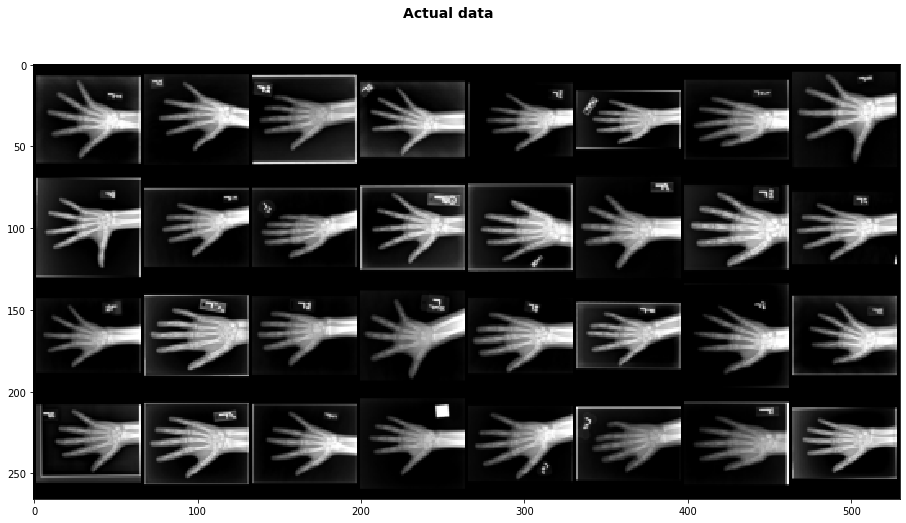

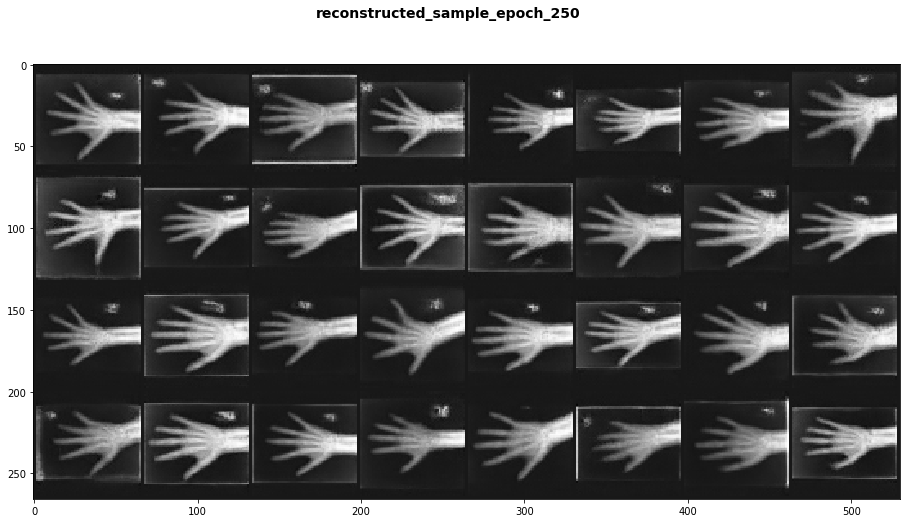

In [15]:
# YOUR CODE HERE
# Create some fixed noise and batch for sampling and reconstruction
fixedNoise = Variable(torch.randn(trainingParameters[BATCH_SIZE_LABEL], trainingParameters[HIDDEN_SIZE_LABEL])).cuda()
data = next(iter(testLoader))
data = data.to(device=device, dtype=torch.float)
fixedBatch = Variable(data).cuda()

reconstructedImage, _ = utils.getGeneratedImages(generator, fixedBatch, fixedNoise, trainingParameters[MAX_EPOCHS_LABEL])
fixedBatchImage = np.squeeze(fixedBatch[0].data)

fixedBatchImageGrid = make_grid(fixedBatch.data)
squeezedFixedBatchImageGrid = np.squeeze(next(iter(fixedBatchImageGrid)))

utils.showImage("Actual data",  squeezedFixedBatchImageGrid)
utils.showImage(reconstructedImage[0], reconstructedImage[1])

imageDifference = MSELoss()
meanSquaredError = imageDifference(squeezedFixedBatchImageGrid, reconstructedImage[1])

print("Mean Squared Error: ", numpy_from_tensor(meanSquaredError))

### REPORT

*Describe here the quality of the recontructions and the numerical results.*

_______________________________


The reconstructions seem to pretty good. This can be further validated by the mean squared error (MSE) of only ~0.004. It is worth noting that the network is not specifically trained for MSE loss and the fact that we have such a low error is impressive.

Furthermore, we generate the reconstructions with unseen data from the test dataloader to ensure that we're not just recreating already seen data.

_______________________________


# Part 6 - Comparison to the standard VAE (without the GAN loss)

Now reproduce the experiment above but by training a network with only the VAE part, i.e. without the GAN loss. How do they compare? 

In [16]:
# YOUR CODE HERE
# Enforce some gan control to remove the gan loss from the equation
trainingParameters[GAN_CONTROL_LABEL] = True
trainingParameters[SAMPLE_WHILE_TRAINING_LABEL] = False
trainingParameters[PERMANENT_PATH_LABEL] = '/content/drive/My Drive/vae'

# Train the network
vaeGenerator = experiment(trainingParameters)

[0/250]: Total Loss=5072
[1/250]: Total Loss=4125
[2/250]: Total Loss=5347
[3/250]: Total Loss=5298
[4/250]: Total Loss=5125
[5/250]: Total Loss=3093
[6/250]: Total Loss=2852
[7/250]: Total Loss=5362
[8/250]: Total Loss=3154
[9/250]: Total Loss=4962
[10/250]: Total Loss=9843
[11/250]: Total Loss=4295
[12/250]: Total Loss=11723
[13/250]: Total Loss=4290
[14/250]: Total Loss=2502
[15/250]: Total Loss=4867
[16/250]: Total Loss=4053
[17/250]: Total Loss=2888
[18/250]: Total Loss=3872
[19/250]: Total Loss=2577
[20/250]: Total Loss=3266
[21/250]: Total Loss=2774
[22/250]: Total Loss=2031
[23/250]: Total Loss=2887
[24/250]: Total Loss=5053
[25/250]: Total Loss=3062
[26/250]: Total Loss=3443
[27/250]: Total Loss=2903
[28/250]: Total Loss=1666
[29/250]: Total Loss=4784
[30/250]: Total Loss=1693
[31/250]: Total Loss=2106
[32/250]: Total Loss=1775
[33/250]: Total Loss=15013
[34/250]: Total Loss=3759
[35/250]: Total Loss=2191
[36/250]: Total Loss=1962
[37/250]: Total Loss=1987
[38/250]: Total Loss

Mean Squared Error (vaegan vs vae):  0.017293267
Mean Squared Error (real vs vae):  0.023424575


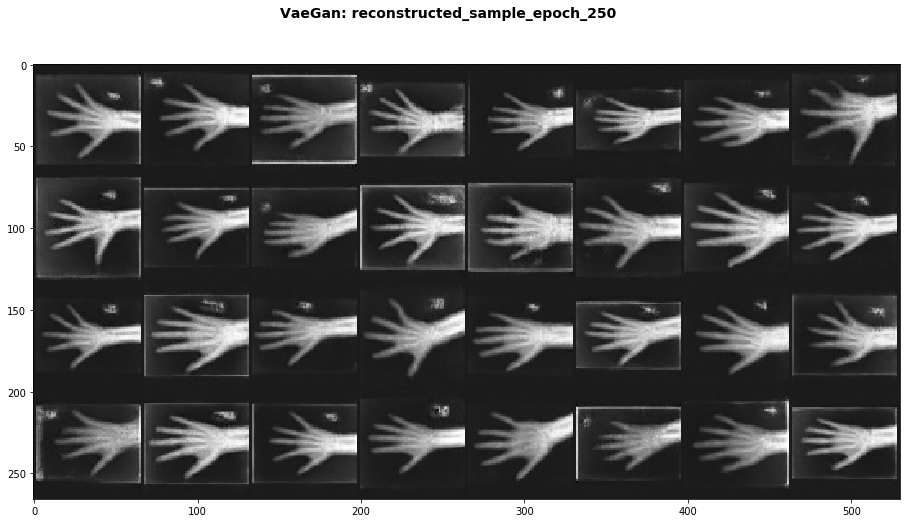

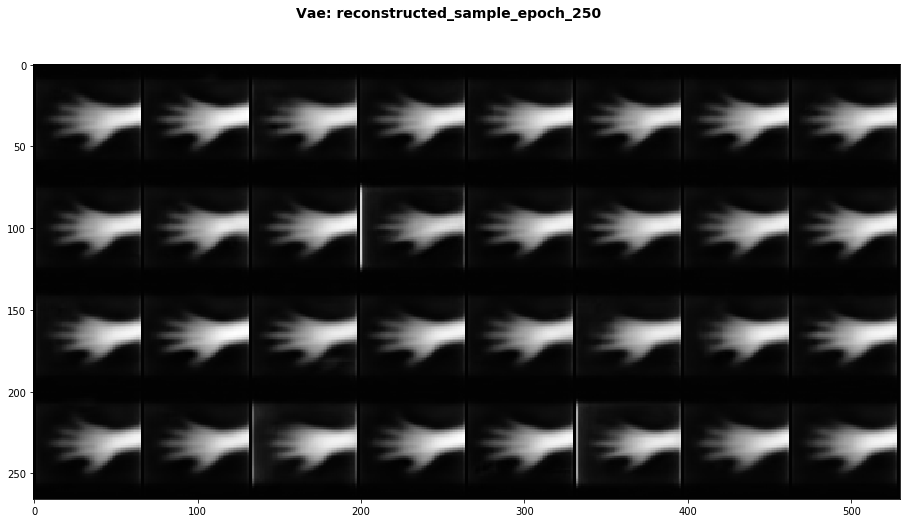

In [17]:
vaeReconstructedImage, _ = utils.getGeneratedImages(vaeGenerator, fixedBatch, fixedNoise, trainingParameters[MAX_EPOCHS_LABEL])
vaeGanReconstructedImage, _ = utils.getGeneratedImages(generator, fixedBatch, fixedNoise, trainingParameters[MAX_EPOCHS_LABEL])

utils.showImage("VaeGan: %s" % vaeGanReconstructedImage[0], vaeGanReconstructedImage[1])
utils.showImage("Vae: %s" % vaeReconstructedImage[0],  vaeReconstructedImage[1])

imageDifference = MSELoss()
meanSquaredError = imageDifference(vaeReconstructedImage[1], vaeGanReconstructedImage[1])
print("Mean Squared Error (vaegan vs vae): ", numpy_from_tensor(meanSquaredError))

meanSquaredError = imageDifference(vaeReconstructedImage[1], squeezedFixedBatchImageGrid)
print("Mean Squared Error (real vs vae): ", numpy_from_tensor(meanSquaredError))

### REPORT

*Describe here the quality of the recontructions and the numerical results, when compared to the VAE-GAN ones. Which ones are better?*

_______________________________


The reconstructions without the Gan part are as expected. While the VAE manages to create a nice outline of the hand,it is blurry and lacks the sharpness provided by adding the GAN loss to the equation.

In terms of MSE, the VAEGAN and the VAE images are very close. VAE images have a good MSE because it's one of the losses we are optimising for

In terms of reconstruction, the VAEGAN outclasses the VAE.

_______________________________


# Part 7 - Generate Samples

Lastyly, given that both the VAE and VAE-GAN models are generative, generate random samples from each model and plot them. Comment on their visual apperance. 

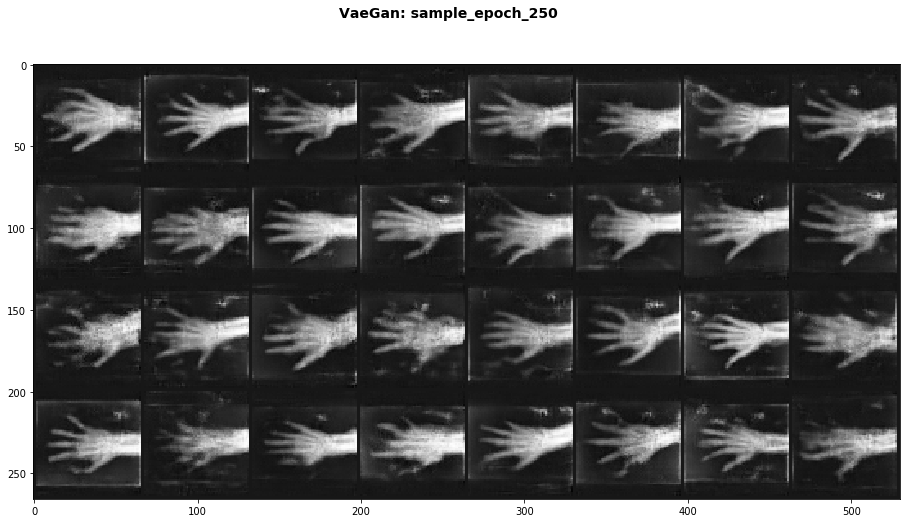

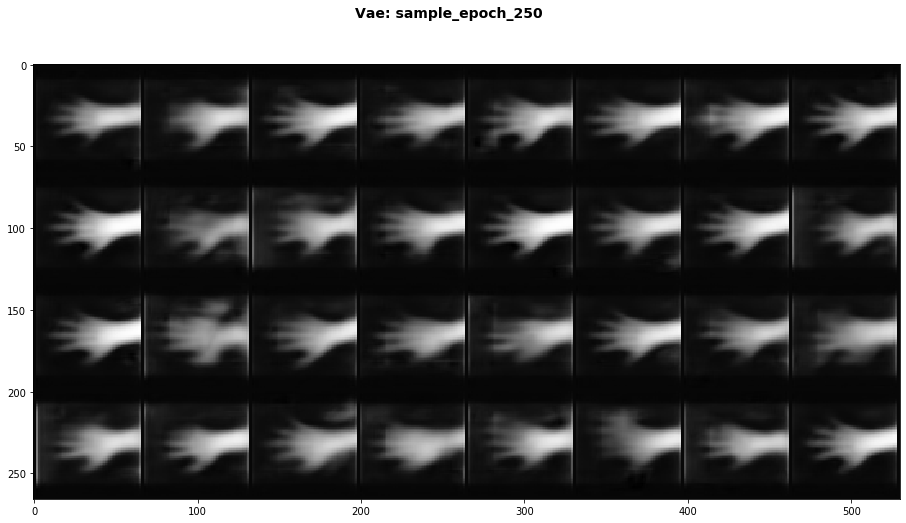

In [18]:
# YOUR CODE HERE
_, sampleImage = utils.getGeneratedImages(generator, fixedBatch, fixedNoise, trainingParameters[MAX_EPOCHS_LABEL])
utils.showImage("VaeGan: %s" % sampleImage[0], sampleImage[1])

_, sampleImage = utils.getGeneratedImages(vaeGenerator, fixedBatch, fixedNoise, trainingParameters[MAX_EPOCHS_LABEL])
utils.showImage("Vae: %s" % sampleImage[0], sampleImage[1])


### REPORT

*Describe here the quality of the generated data and compare between VAE and VAE-GAN.* 

_______________________________


Similar to the previous section, the VAE produces a blurry sample of the hand.
On the other hand, the VAEGAN manages to add sharpness to the image at the cost of stability. What we mean by this is that even though some hands are very nicely detailed, others have weird fingers and other weird looking deformities.

Perhaps if we didn't downscale the image so much (original was x258 and we scaled it down to x64), we would have much different results (in terms of the VaeGan sampling).

_______________________________
